# load data

download dataset from kaggle [https://www.kaggle.com/xainano/handwrittenmathsymbols](https://www.kaggle.com/xainano/handwrittenmathsymbols) (a large `rar` file within `zip` file), and extract the images. The folder structure should be similar as below

```bash
Team-3-Quantum-Hackers-Project/
├── README.md
├── LICENSE
├── .gitignore
├── load_data.ipynb
└── extracted_images/
    ├── 0/
    |   ├── 0_100070.jpg
    |   ├── 0_100080.jpg
    |   ├── 0_100081.jpg
    |   └── ...
    ├── 1/
    ├── !/
    ├── (/
    ├── )/
    └── ...
```

In [1]:
import os
import glob
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt

import skimage
import sklearn.model_selection
import sklearn.svm

In [2]:
datadir = 'extracted_images'
all_label = os.listdir(datadir)
all_image_path = {x:[os.path.join(datadir,x,y) for y in os.listdir(os.path.join(datadir,x))] for x in all_label}
    
print('all label:', all_label)
print('some image path:')
for x in list(all_image_path.keys())[:4]:
    print(x, all_image_path[x][:2])

all label: ['beta', 'infty', 'cos', '6', '0', 'prime', '=', 'gt', 'o', 'lt', 'y', 'b', '!', 'T', 'C', 'leq', 'R', 'exists', 'p', 'N', '3', '{', 'H', 'z', 'ascii_124', 'alpha', 'sigma', '9', 'int', 'q', 'l', 'lambda', 'A', 'theta', '2', 'S', '5', 'sqrt', '7', 'sum', '4', 'v', 'e', 'M', 'forall', 'j', '-', ')', '1', 'w', '(', 'phi', 'i', ',', 'lim', 'Delta', 'G', '8', 'u', 'k', 'rightarrow', 'div', 'neq', '[', 'pi', ']', 'f', 'geq', 'pm', 'forward_slash', 'gamma', '}', 'X', '+', 'times', 'log', 'tan', 'd', 'in', 'sin', 'ldots', 'mu']
some image path:
beta ['extracted_images/beta/beta_57145.jpg', 'extracted_images/beta/exp26500.jpg']
infty ['extracted_images/infty/exp96368.jpg', 'extracted_images/infty/exp78043.jpg']
cos ['extracted_images/cos/exp48148.jpg', 'extracted_images/cos/exp91430.jpg']
6 ['extracted_images/6/exp22030.jpg', 'extracted_images/6/6_56393.jpg']


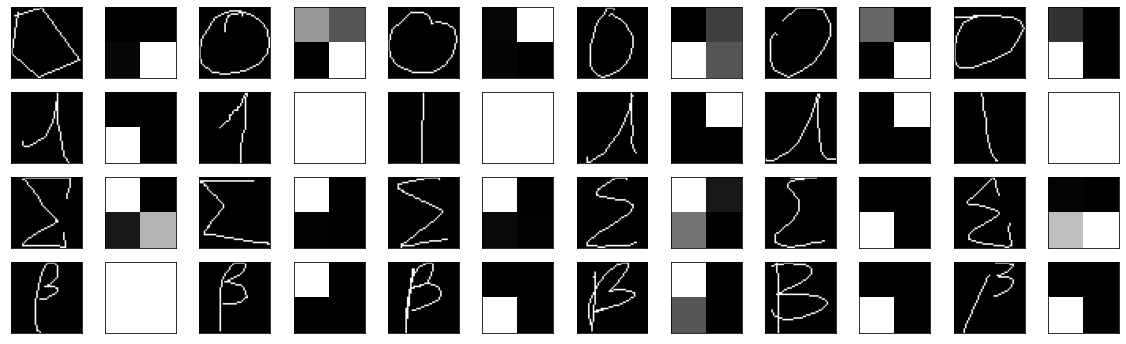

In [3]:
plot_label_list = ['0', '1', 'sum', 'beta']
num_column = 6
resize_image_size = 2,2
fig, ax_list = plt.subplots(nrows=len(plot_label_list), ncols=2*num_column, figsize=(20, 6))
for i in range(len(plot_label_list)):
    image_list = all_image_path[plot_label_list[i]]
    random_index = np.random.choice(np.arange(len(image_list)), size=num_column)
    for j in range(num_column):
        path = image_list[random_index[j]]
        image = np.array(PIL.Image.open(path))
        # image_small = np.array(PIL.Image.open(path).resize((resize_image_size[1],resize_image_size[0]))) #resize(width,height)
        image_small = skimage.transform.resize(image, resize_image_size, anti_aliasing=False)
        ax_list[i,2*j].imshow(image, cmap=plt.cm.gray_r)
        ax_list[i,2*j].set_xticks([])
        ax_list[i,2*j].set_yticks([])
        ax_list[i,2*j+1].imshow(image_small, cmap=plt.cm.gray_r)
        ax_list[i,2*j+1].set_xticks([])
        ax_list[i,2*j+1].set_yticks([])

**TODO**: how to combine it with Quantum Machine Learning

quantum SVM? CircuitQNN?

## preprocess data

1. select label
2. select part of the data, otherwise itt takes too long to train on the whole dataset
3. split train and test set

In [4]:
# binary classification
labels = ['0', '1']
label_to_int = {labels[0]:0, labels[1]:1}
class_size = 240
resize_image_size = 2,2
seed = None #to fix the result, change it to seed=23 or some other integer

data_list = []
label_list = []
for x in labels:
    image_list = all_image_path[x]
    random_index = np.random.choice(np.arange(len(image_list)), size=class_size)
    for i in random_index:
        path = image_list[i]
        data_list.append(np.array(PIL.Image.open(image_list[i])))
        label_list.append(label_to_int[x])

data_list = [skimage.transform.resize(x, resize_image_size, anti_aliasing=False).reshape(-1) for x in data_list]
data_list = np.stack(data_list)
label_list = np.array(label_list)
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
            data_list, label_list, test_size=0.2, shuffle=True, random_state=seed)

## quantum SVM

In [5]:
import concurrent.futures
import qiskit
import qiskit.providers.aer
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, PauliFeatureMap, TwoLocal
from qiskit.algorithms.optimizers import SPSA, COBYLA, GradientDescent
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.neural_networks import CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.utils.loss_functions import L2Loss, CrossEntropyLoss

In [6]:
# run qiskit parallelly see https://qiskit.org/documentation/apidoc/parallel.html
# I tried and find it doesn't help a lot
# aer_qasm_sim = qiskit.providers.aer.QasmSimulator()
# aer_qasm_sim.set_options(executor=concurrent.futures.ThreadPoolExecutor(max_workers=4)) #use max_workers of your computer
# aer_qasm_sim.set_options(max_job_size=4) #doesn't help
# qi_aer_qasm = qiskit.utils.QuantumInstance(aer_qasm_sim, shots=1024, seed_simulator=seed)

aer_qasm_sim = qiskit.providers.aer.QasmSimulator()
qi_aer_qasm = qiskit.utils.QuantumInstance(aer_qasm_sim, shots=1024, seed_simulator=seed)

In [7]:
feature_dim = 4

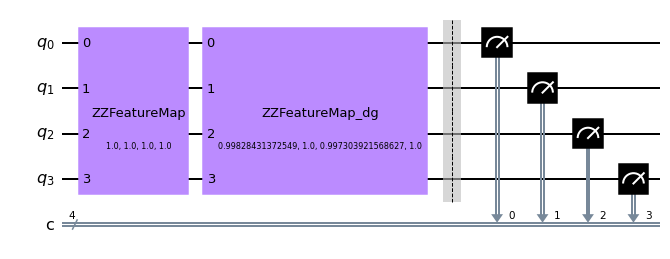

In [8]:
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement='linear')
# feature_map = PauliFeatureMap(feature_dimension=feature_dim, reps=1, entanglement='linear')
feature_kernel = QuantumKernel(feature_map=feature_map, quantum_instance=qi_aer_qasm)

#Constructing the inner product circuit for given datapoints and feature map
pauli_circuit = feature_kernel.construct_circuit(x_train[0], x_train[1])
pauli_circuit.decompose().draw('mpl')

In [9]:
x_train.max(),x_train.min()

(1.0, 0.001715686274509804)

In [10]:
def normalize(x):
    # put data in [-1,1] range
    x = x*2-1
    return x

In [11]:
# it's really slooooow to run with 480 samples
model = sklearn.svm.SVC(kernel= feature_kernel.evaluate)

#Fiting the SVM model according to the given training data.
model.fit(normalize(x_train), y_train)

SVC(kernel=<bound method QuantumKernel.evaluate of <qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x7f47a4545280>>)

In [12]:
accuracy = model.score(normalize(x_train), y_train)
print(f'classification accuracy on train set (size={len(y_train)}): {accuracy}')

accuracy = model.score(normalize(x_test), y_test)
print(f'classification accuracy on test set (size={len(y_test)}): {accuracy}')
# not good, seems just random guess with accuracy 0.5

classification accuracy on train set (size=384): 0.6979166666666666
classification accuracy on test set (size=96): 0.14583333333333334


## Quantum Neural Network

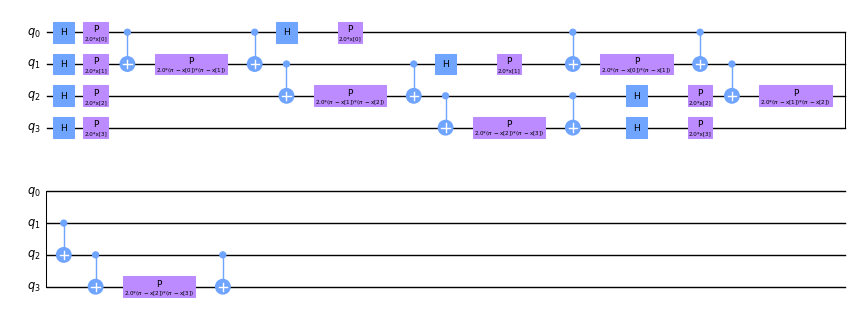

In [13]:
fmap_zz = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement='linear')
fmap_zz.decompose().draw('mpl', scale=0.7)

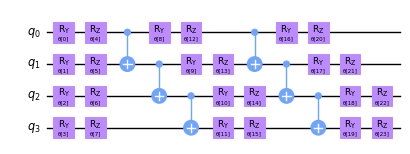

In [14]:
ansatz_tl = TwoLocal(num_qubits=feature_dim, rotation_blocks=['ry', 'rz'],
                         entanglement_blocks='cx', entanglement='linear', reps=2)

weights = np.random.random(len(ansatz_tl.parameters))
ansatz_tl.bind_parameters(weights)
ansatz_tl.decompose().draw('mpl', scale=0.7)

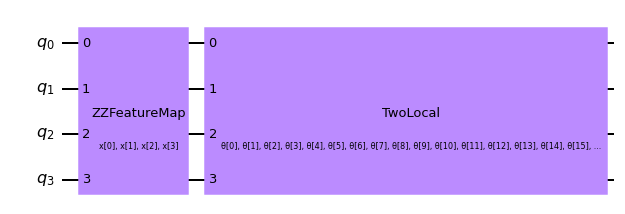

In [15]:
var_circuit = fmap_zz.compose(ansatz_tl)
var_circuit.draw('mpl')

In [16]:
def parity(x, num_classes):
    return f"{x:b}".count("1") % num_classes

def one_qubit_binary(x):
    return x % 2

In [17]:
num_classes = 2
#circuitQNN return measurements
qnn = CircuitQNN(circuit=var_circuit,
                 input_params=fmap_zz.parameters,  # if your embedding strategy is not a parametrized circuit 
                                                   # (e.g. amplitude encoding) you will have to do some extra work!
                 weight_params=ansatz_tl.parameters,  # if you train your embedding as well, the trainable
                                                      # parameters of the embedding must be added
                 interpret=one_qubit_binary,
                 output_shape=num_classes,
                 gradient=None,
                 quantum_instance=qi_aer_qasm)

In [18]:
def callback(nfev, params, fval, stepsize, accepted=None):
    """
    Can be used for SPSA and GradientDescent optimizers
    nfev: the number of function evals
    params: the current parameters
    fval: the current function value
    stepsize: size of the update step
    accepted: whether the step was accepted (not used for )
    """
    loss_recorder.append(fval)
    if nfev%21==0: #print less
        print(f'{nfev} - {fval}')

def normalize(x):
    x = x*2-1
    # x = x/np.linalg.norm(x, axis=1, keepdims=True) #not good
    return x

def get_one_hot_encoding(y):
    unique_labels = np.unique(y, axis=0)
    y_one_hot = [(np.eye(len(unique_labels))[np.where(unique_labels == y_i)]).reshape(len(unique_labels)) for y_i in y]
    return np.array(y_one_hot)

y_train_1h = get_one_hot_encoding(y_train)
y_test_1h = get_one_hot_encoding(y_test)

In [19]:
# a little bit slow for 240 samples, but much faster than quantum SVM
max_itr = 100
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
initial_point = np.random.random((len(ansatz_tl.parameters),))
vqc = NeuralNetworkClassifier(neural_network=qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)

vqc = vqc.fit(normalize(x_train), y_train_1h)

21 - 401.73842909523785
42 - 382.21776944353496
63 - 376.98601931499866
84 - 374.9259485647576
105 - 373.19676991521754
126 - 375.2799354799737
147 - 371.5364795925083
168 - 372.762086941849
189 - 370.1060045977021
210 - 371.0176196050429
231 - 369.9452198423597
252 - 366.9365239636337
273 - 367.29155071763216
294 - 368.5259055855911


accuracy on the train set (size=384): 0.640625
accuracy on the test set (size=96) 0.6979166666666666


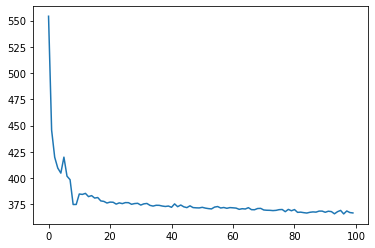

In [20]:
plt.plot(loss_recorder)

train_accuracy = vqc.score(normalize(x_train), y_train_1h)
test_accuracy = vqc.score(normalize(x_test), y_test_1h)
print(f'accuracy on the train set (size={len(x_train)}): {train_accuracy}')
print(f'accuracy on the test set (size={len(x_test)}) {test_accuracy}')
# not good either, almost random guess: 11/20=0.55

## TODO

how about making a comparison between quantum SVM and QNN, in the aspects of time, and accuracy